# Introduction 

Fibonacci heap is a theoretical improvement from regular min- or max-ordered heap. A Fibonacci heap is a data structure that supports a priority queue's operations (insertion, deletion, optimum extraction, etc.) Fibonacci heaps can implement some of those operations in amortized constant time (Cormen et al.) The figure below compares the running time of some operations of both a regular and a Fibonacci heap supports.
![operations comparison](images/operations_comp.png)

It can be seen from the above figure that for a Fibonacci heap, five out of the seven operations run in constant amortized time. The other two run in logarithmic time. Insertion, union, and decreasing key are three outstanding operations, as they run in constant amortized time for Fibonacci heaps but in either $\Theta(log n)$ or $\Theta(n)$ for a regular heap. 

This paper gives the empirical evidence for the performance of both Fibonacci heaps and regular heaps on those three operations. Section 2 gives an overview about Fibonacci heap and presents its implementation in Python. Section 3 explains in detail the running times of the operations and carries out a set of experiments to contrast the performance of a Fibonacci heap and a regular heap. Section 4 discusses the results.

# Fibonacci Heap and its Implementation

Below is the implementation of Fibonacci heap in Python. The description (adapted from Cormen et al.) for each operation documented in the code serves as an overview for the data structure and how it works.

In [10]:
# Import useful packages
import math
import numpy as np
from heapq import heappush, heappop, merge
import time
import random
from matplotlib import pyplot as plt
import copy

In [3]:
# mergeable-heap operations (make-heap, insert,
# minimum, extract-min, and union) for users to use.
# Users don't have to instantiate from the class Fheap 
# themselves.

def makefheap():
    """ make-heap in Cormen et al."""
    heap = Fheap()
    return heap
def fheappush(heap, item):
    """ insert in Corment et al."""
    heap.insert(Node(item))
def getfheapmin(heap):
    """ minimum in Corment et al."""
    return heap.min.key
def fheappop(heap):
    """ extract-min in Corment et al."""
    return heap.extract_min().key
def fheapunion(heap, other):
    """ union in Corment et al."""
    heap.union(other)

class Node:
    """ Support:
    - add_child: add a child to the node
    - remove_child: remove a child to the node
    """
    def __init__(self, key, p=None, left=None, right=None, 
                 child=None, mark = None):
        """ create a new node in a heap
        
        - self.key: the node's key, a number
        - self.left, self.right: the node's adjacent siblings.
        The node and its siblings are doubly linked, so they
        form a circular loop. If x is an only child, it is
        its own left and right sibling.
        - self.child: the representative 
        child of the node. To access all the children of
        the node, first access the representative child 
        through self.child, then access all the child's 
        siblings through self.left or self.right.
        - self.p: the node's parent
        - self.degree: the number of the node's children
        - self.mark: (description by Cormen et al.) indicate
        whether the node has lost a child since the last time 
        it was made the child of another node. Newly created nodes
        are unmarked. A node becomes unmarked whenever it is made
        the child of another node. 
        """
        self.key = key
        self.left = left
        self.right = right
        self.p = p # parent
        self.child = child # to any one of its children 
        self.degree = 0 
        self.mark = False if not mark else mark
    
    def add_child(self, x):
        """ add a child to the node. If the node currently
        has no children, the child is made the representative
        child, otherwise, it is added to the right of the 
        representative child. 
        
        This procedure updates the child's parent and mark, 
        and the node's degree
        """
        if not self.child:
            self.child = x
            x.left, x.right = x, x
        else:
            right_to_child = self.child.right
            self.child.right = x
            x.left = self.child
            x.right = right_to_child 
            right_to_child.left = x
        x.p = self
        self.degree += 1
        x.mark = False
    
    def remove_child(self, x):
        """ remove a child from the node's child list. This
        procedure does not update the child's parent and does
        not allow removing a child that does not exist. Updating
        the child's parent is the reponsibility of routines that 
        call this function. 
        """
        if not self.child:
            raise ValueError('Child list is currently empty')
        if self.degree == 1: # has 1 child
            self.child = None
        else: # >= 2 children
            if self.child is x:
                self.child = x.right
            left_to_x, right_to_x = x.left, x.right
            left_to_x.right = right_to_x
            right_to_x.left = left_to_x
        self.degree -= 1

class Fheap:
    """ Support insert, minimum, extract_min, union,
    decrease_key, delete"""
    
    def __init__(self, minimum=None):
        """ create a new, empty heap
        
        - self.min: points to the node that contains
        the minimum key
        - self.num_nodes: number of nodes currently
        in the heap
        - self.num_trees: number of roots in the tree
        A Fibonacci heap can contain many trees of 
        min-ordered heap. The roots of these trees are
        doubly linked and form a circular loop as in the
        case with siblings. The number of trees of a 
        Fibonacci heap is always the number of roots.
        - self.num_marks: number of marked nodes in 
        the heap
        """
        self.min = minimum 
        self.num_nodes = 0 
        self.num_trees = 0 
        self.num_marks = 0 

    def remove_root(self,x):
        """ remove a root from the list of roots of the
        heap. This only updates the pointers of the 
        remaining roots and the number of trees of the 
        heap, but does not update the pointers
        of the removed root or those of its children. 
        Those are the responsibility of the routines that
        call this function
        """
        right_to_x, left_to_x = x.right, x.left
        right_to_x.left = left_to_x
        left_to_x.right = right_to_x
        self.num_trees -= 1
        
    def add_root(self, x):
        """ add a root to the list of roots of the heap.
        If the heap is currently empty, the added root 
        is the min of the heap and is its own left and 
        right roots. 
        """
        if self.min == None:
            x.left, x.right = x, x
        else:
            right_to_min = self.min.right
            self.min.right = x
            x.left = self.min
            x.right = right_to_min
            right_to_min.left = x
        self.num_trees += 1
        
    def insert(self, x):
        """ add a node. This simply adds the node as a
        root of the heap, updates the minimum node of 
        the heap if necessary, and updates the number
        of nodes. For example,
        
        - Before insertion, one root ((2)), minimum = (2):
                (2)
               /   \
              (3)  (4)
        
        - After inserting (1), two roots ((1) and (2)),
        minimum = (1):
                (2)---(1)
               /   \
              (3)  (4)         
        """
        if self.min == None:
            self.add_root(x)
            self.min = x
        else:
            self.add_root(x)
            if x.key < self.min.key:
                self.min = x
        self.num_nodes += 1

    def minimum(self):
        """ return the node with the minimum key
        """
        return self.min
    
    def extract_min(self):
        """ remove and return the minimum node
        This procecures moves each of the minimum node's 
        children to the root list, removes the minimum
        node itself from the root list, and "consolidate"
        (see the documentation for consolidate) the 
        resulted tree. 
        """
        z = self.min
        if z != None:
            x = z.child
            for i in range(z.degree):
                y = x.right
                self.add_root(x)
                x.p = None
                x = y
            if z.mark:
                self.num_marks -= 1
            self.remove_root(z)
            if z == z.right:
                self.min = None
            else:
                self.min = z.right
                self.consolidate()
            self.num_nodes -= 1
        return z
            
    def consolidate(self):
        """ The goal is to reduce the number of trees in
        the current heap. The procedure is as follows
        (description by Corment et al.):
        1. Find two roots that have the same degree (the 
        same number of children)
        2. Merge the two trees rooted at those two roots 
        by making the root with larger key one child of
        the one with smaller key. This procedure is called 
        link (see the documentation for link)
        3. Repeat step 1 and 2 until no two roots in the 
        tree have the same degree
        
        For example,
        
        - Before consolidating: 3 roots ((1),(4), and (5)),
        root (1) and (4) have the same degree of 1
            (1)---(4)---(5)
             |     |
            (3)   (6)
        
        - After consolidating: 2 roots ((1) and (5)), root
        (1) has degree 2 while root (5) has degree 0.
            (1)---(5)
           /   \
          (3)  (4)
                |
               (6)
        """
        A = [None] * self.num_nodes
        root = self.min
        counter = self.num_trees
        while counter:
            x = root
            root = root.right
            d = x.degree
            while A[d]:
                y = A[d]
                if x.key > y.key:
                    x,y = y,x    
                self.link(y, x)
                A[d] = None
                d += 1
            A[d] = x
            counter -= 1
        self.min = None
        for i in range(len(A)):
            if A[i]:
                if self.min == None:
                    self.min = A[i]
                else:
                    if A[i].key < self.min.key:
                        self.min = A[i]
                        
    def link(self, y, x): # y>x
        """ Link y to x. This procesure makes y a child
        of x. Because when a node becomes a child of another,
        it has no mark, so the number of marks of the heap is
        updated if necessary.
        """
        self.remove_root(y)
        if y.mark == True:
            self.num_marks -= 1
        x.add_child(y)
 
    def union(self, other):
        """ Make a union of two heaps. This procedure simply
        concatenates the two root lists and updates the 
        minimum node, the number of nodes, the number trees, 
        and the number of marks of the heap.
        """
        if not self.min:
            self.min = other.min
        elif other.min:
            self_first_root, other_last_root = self.min.right, other.min.left
            self_first_root.left = other_last_root
            self.min.right = other.min
            other.min.left = self.min
            other_last_root.right = self_first_root
        
        if (self.min == None) or (other.min != None and other.min.key < self.min.key):
            self.min = other.min
        self.num_nodes += other.num_nodes
        self.num_trees += other.num_trees
        self.num_marks += other.num_marks

    def decrease_key(self, x, k):
        """ Decrease node x's key to k. k must be larger than the
        current key of x. If by decreasing x's key to k, the heap
        invariant is violated, x (and therefore along with its 
        children) will be cut from its current tree and added to 
        the root list (see the function cut). The parent y of x may 
        have had lost one of its child before. If this is the case
        and if y is not a root, then y is, in turn, cut from its 
        parent. The nodes are continually cut using cascading_cut
        until it "finds either a root or an unmark node" (Cormen
        et al.).
        """
        if k > x.key:
            raise ValueError('new key is greater than current key')
        x.key = k
        y = x.p
        if y and x.key < y.key:
            self.cut(x, y)
            self.cascading_cut(y)
        if x.key < self.min.key:
            self.min = x
    
    def cut(self, x, y):
        """ Cut x from y and make it a root. x's parent is
        set to None and x's mark and the heap's number of
        marks are updated if necessary.
        """
        if x.mark:
            self.num_marks -= 1
            x.mark = False
        y.remove_child(x)
        self.add_root(x)
        x.p = None
        
    def cascading_cut(self, y):
        """ Cut continually until it finds either a root or an
        unmarked node.
        """
        z = y.p
        if z:
            if not y.mark:
                y.mark == True
                self.num_marks += 1
            else:
                self.cut(y, z)
                self.cascading_cut(z)
    
    def delete(self, x):
        """ Remove x from the heap by first setting its key to
        minus infinity and extracting the heap's min.
        """
        class MaskClass:
            def __lt__(self, other):
                return True
            
            def __gt__(self, other):
                return False
            
        mask_key = MaskClass() # the key is smaller than any
                               # other keys
        self.decrease_key(x, mask_key)
        self.extract_min()

In [4]:
### TEST 1 ###
# This is the test for mergeable-heap operations (make-heap,
# insert, minimum, extraxt-min, union)
fheap1 = makefheap()
fheap2 = makefheap()
num_list1 = list(range(50))
num_list2 = list(range(50,100))
# shuffle the list
np.random.shuffle(num_list1)
np.random.shuffle(num_list2)
for num in num_list1:
    fheappush(fheap1, num)
for num in num_list2:
    fheappush(fheap2, num)
# unify two heaps
fheapunion(fheap1, fheap2)
print('Minimum of heap:', getfheapmin(fheap1))
sorted_list = []
for _ in range(fheap1.num_nodes):
    sorted_list.append(fheappop(fheap1))

print(sorted_list)
print(sorted_list == list(range(100)))

Minimum of heap: 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
True


In [5]:
### TEST 2 ###
# same test as above, but for when keys are non-number 
# items (e.g., tuples)
item_list = [(3, 'a'),(0, 'z'), (2,'m'), (-2, 'r')]

fheap1 = makefheap()
fheap2 = makefheap()
item_list1 = [(3, 'a'),(0, 'z'), (2,'m'), (-2, 'r')]
item_list2 = [(7, 'a'),(-1, 'z'), (5,'m'), (9, 'r')]
for num in item_list1:
    fheappush(fheap1, num)
for num in item_list2:
    fheappush(fheap2, num)
# unify two heaps
fheapunion(fheap1, fheap2)
print('Minimum of heap:', getfheapmin(fheap1))
sorted_list = []
for _ in range(fheap1.num_nodes):
    sorted_list.append(fheappop(fheap1))
print(sorted_list)



Minimum of heap: (-2, 'r')
[(-2, 'r'), (-1, 'z'), (0, 'z'), (2, 'm'), (3, 'a'), (5, 'm'), (7, 'a'), (9, 'r')]


In [6]:
### TEST 3 ###
# This is the test for non-mergeable-heap operations
# (decrease-key and delete)
fheap = Fheap()
key_list = list(range(100))
np.random.shuffle(key_list)
nodes = [Node(key) for key in key_list]
for node in nodes:
    fheap.insert(node)
# test decrease_key
for node in nodes:
    fheap.decrease_key(node, node.key-20)
# test delete
for node in nodes[50:]:
    fheap.delete(node)
sorted_list = []
for _ in range(fheap.num_nodes):
    sorted_list.append(fheap.extract_min().key)
print(sorted_list)

[-17, -16, -13, -12, -10, -9, -8, -5, -4, 2, 9, 10, 11, 12, 13, 14, 16, 19, 22, 24, 29, 31, 32, 34, 36, 39, 42, 45, 46, 47, 49, 51, 53, 54, 55, 59, 61, 62, 63, 64, 66, 67, 68, 69, 72, 74, 75, 76, 77, 78]


In [7]:
### TEST 4 ###
fheap = Fheap()
item_list = []
item_list = [(i, random.randint(0,100)) for i in range(20)]
np.random.shuffle(item_list)
nodes = [Node(item) for item in item_list]
for node in nodes:
    fheap.insert(node)
# test decrease_key
for node in nodes:
    fheap.decrease_key(node, (node.key[0]-5,node.key[1]))
# test delete
for node in nodes[10:]:
    fheap.delete(node)
sorted_list = []
for _ in range(fheap.num_nodes):
    sorted_list.append(fheap.extract_min().key)
print(sorted_list)

[(-4, 19), (-3, 15), (0, 59), (1, 84), (3, 99), (9, 45), (10, 28), (11, 64), (12, 48), (13, 14)]


# The Experiment

It is claimed that the Fibonacci heap performs poorly in practice compared to the regular heap due to the Fibonacci heap's large constant factors, despite its superior theoretical run times (Cormen et al. p. 507; Brodal, Lagogiannis, & Tarjan.) The following set of experiments investigates this claim, primarily on the practical running times of insertion, union, and key decrease, as these are the operations the Fibonacci is proven to have better theoretical amortized running times for. The experiments used the library `heapq` for implementation of ordinary heap 

## The Insert Operation 

Inserting a node of key $k$ into an ordinary binary heap involves the following steps:
1. Increment the heap size by 1. This takes $T_1=\Theta(1)$ worst-case time. 
2. Assigning $+\infty$ to the key of the last position of the heap. This also takes a constant time, $T_2=\Theta(1)$ worst-case.
3. Calling decrease the key of the last position from $+\infty$ to $k$. This requires continually swapping the key with its parent until the min-heap invariant is preserved (the child is no smaller than the parent). In the worst case, the inserted node has to travel all the way from the leave to the root. As swapping takes constant time $\Theta(1)$, inserting a node, therefore, takes $\Theta(1)*h=\Theta(h)$ in the worst case, with $h$ being the height of the heap. Because an $n$-element heap has height of $\lfloor log\:n \rfloor =\Theta(log\:n)$, the run time of this step is $T_3=\Theta(h)=\Theta(log\:n)$
Overall, the running time of inserting a node to an $n$-element ordinary heap is, in the worst case,
$$T_{regular\:heap}=T_1+T_2+T_3=\Theta(1)+\Theta(1)+\Theta(log\:n)=\Theta(log\:n)$$

Inserting the node of key $k$ into a Fibonacci heap is simply adding the the node to the root list of the heap by 1) updating the nodes left and right siblings, 2) setting the node to be the min of the heap if its key is smaller than the current minimum node's key, and 3) updating the heap's size. Each of the operations listed takes $\Theta(1)$ worst-case time. Therefore, although the table presented at the beginning of this paper states that inserting to Fibonacci heaps takes a constant amortized time, the worst-case run time is also constant, $$T_{Fibonacci\:heap}=\Theta(1)$$

This is not a trivial observation, as worst-case time implies amortized time, but the other way around is not true: amortized time is not necessarily the worst-case time.

Some other operations' run times of the Fibonacci heap presented in figure 1 can also actually be stated as worst-case times, not just amortized time. These operations include:

1. make-heap: this procedure simply initializes an empty heap by setting some default attributes and thus runs in constant worst-case time.
2. minimum: this returns the pointer to the minimum node, and since this pointer is maintained in every other operations, returning it takes constant worst-case time.
3. union: this 1) concatenates the two root lists of the two heaps, which takes $\Theta(1)$ worst-case time, 2) updates the minimum node by comparing the minimum nodes of the two heaps, taking also $\Theta(1)$ worst-case time, and 3) updates the number of nodes by adding those of the two heaps, taking $\Theta(1)$ worst-case time. The overall running time is, therefore, $\Theta(1)$ worst-case time.

The four (duplicated) experiments below compares the run time of the operation insert of the two data structures with $n$, the number of nodes currently in a heap, being the independent variable. The experiments have to run four times because there is noise and inconsistency in the practical run time.



In [40]:
def insert_exp(iterations):
    heap_times, fheap_times = [], []
    N = []
    for i in np.logspace(0,7,50):
        N.append(i)
        heap = []
        fheap = Fheap()
        num_list = list(range(int(i)))
        nodes = []
        for num in num_list:
            heappush(heap, num)
            nodes.append(Node(num))
        for node in nodes:
            fheap.insert(node)
        heap_time, fheap_time = 0, 0
        j = 1
        for _ in range(iterations):
            start = time.time()
            heappush(heap, i+j)
            heap_time = heap_time + time.time() - start
            
            start = time.time()
            fheap.insert(Node(i+j))
            fheap_time = fheap_time + time.time() - start
            
            heappop(heap)
            fheap.extract_min()
            j += 1
        heap_times.append(heap_time/iterations)
        fheap_times.append(fheap_time/iterations)
    
    plt.plot(N, heap_times, color='red',
             label='regular heap')
    plt.plot(N, fheap_times, color='blue',
             label='Fibonacci heap')
    title = 'Running time of insertions of two data structures'
    plt.title(title)
    plt.xlabel('number of elements in the heap $n$')
    plt.ylabel('seconds')
    plt.legend()
    plt.show()
    return heap_times, fheap_times
            
            

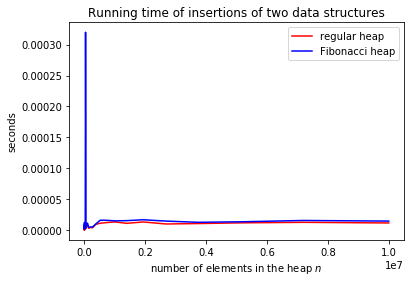

In [41]:
insert_exp1 = insert_exp(10)

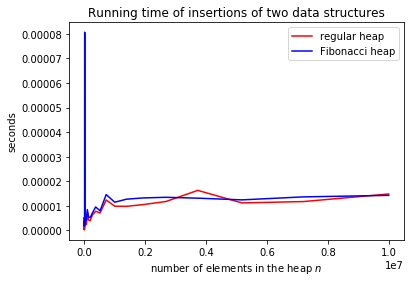

In [44]:
insert_exp2 = insert_exp(10)

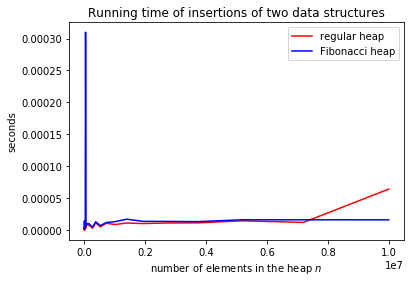

In [45]:
insert_exp3 = insert_exp(10)

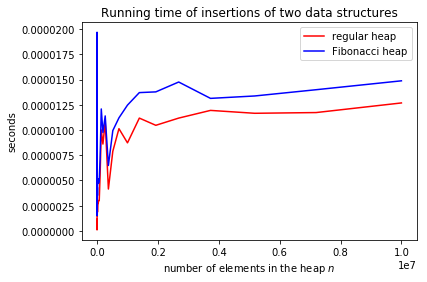

In [46]:
insert_exp4 = insert_exp(10)

We see that despite the superiority in theoretical run time, the insert operation of Fibonacci heap performs no better than that of regular heap. In most of the time, regular heap implements insertion more efficiently even when the heap size $n$ is as large as the 7-th order of magnitude. 

## The Union Operation

Making a union of two ordinary heaps of total size $n$ is claimed to take $\Theta(n)$ worst-case time. This complexity can be accomplished through the algorithm as follows:
1. Concatenate two lists the represent the two heaps, forming a list of size $n$. This step requires adding new empty position to one list, and iterate over every element of the other list to add the one of the empty positions. Thus, this step takes $T_1=\Theta(n/2)=\Theta(n)$ worst case time.
2. Build a new heap from the newly created list of size $n$. This procedure takes $T_2=\Theta(n)$ (Cormen et al.).

Following the above algorithm, the run time of union for regular heaps is $T=T_1+T_2=\Theta(n)+\Theta(n)=\Theta(n)$ worst-case time.

As analyzed in the previous section, the run time of union in Fibonacci heap is $\Theta(1)$ both amortized and worst-case time.

Below is the experiments:

Running times for regular heap: [9.34600830078125e-06, 6.341934204101563e-06, 5.245208740234375e-06, 4.57763671875e-06]
Running times for Fibonacci heap: [5.245208740234375e-06, 5.102157592773437e-06, 4.863739013671875e-06, 4.38690185546875e-06]


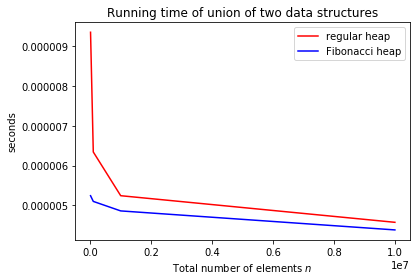

In [19]:
def union_exp():
    iterations = 5
    N = [10**i for i in range(4,8)]
    heap_times = []
    fheap_times = []

    for n in N:
        heap_time = 0
        fheap_time = 0
        for _ in range(iterations):
            heap1, heap2 = [], []
            fheap1, fheap2 = makefheap(), makefheap()
            num_list1 = list(range(n))
            num_list2 = list(range(n,2*n))
            for i in range(n):
                heappush(heap1, num_list1[i])
                heappush(heap2, num_list2[i])
                fheappush(fheap1, num_list1[i])
                fheappush(fheap2, num_list2[i])
            start = time.time()
            merge(heap1, heap2)
            heap_time = heap_time + time.time() - start

            start = time.time()
            fheapunion(fheap1, fheap2)
            fheap_time = fheap_time + time.time() - start

        heap_times.append(heap_time/iterations)
        fheap_times.append(fheap_time/iterations)

    print('Running times for regular heap:', heap_times)
    print('Running times for Fibonacci heap:', fheap_times)
    plt.plot(N, heap_times, color='red',
             label='regular heap')
    plt.plot(N, fheap_times, color='blue',
             label='Fibonacci heap')
    title = 'Running time of union of two data structures'
    plt.title(title)
    plt.xlabel('Total number of elements $n$')
    plt.ylabel('seconds')
    plt.legend()
    plt.show()
union_exp()

Running times for regular heap: [4.482269287109375e-06, 4.76837158203125e-06, 5.626678466796875e-06, 6.198883056640625e-06]
Running times for Fibonacci heap: [4.243850708007813e-06, 4.863739013671875e-06, 4.38690185546875e-06, 4.57763671875e-06]


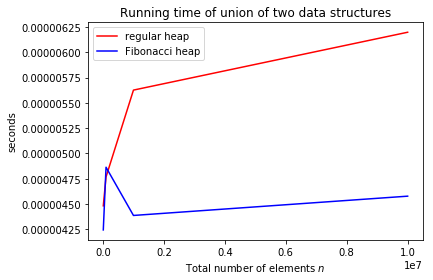

In [20]:
union_exp()

Running times for regular heap: [7.152557373046875e-06, 5.626678466796875e-06, 5.578994750976562e-06, 6.4373016357421875e-06]
Running times for Fibonacci heap: [4.863739013671875e-06, 5.0067901611328125e-06, 6.580352783203125e-06, 6.103515625e-06]


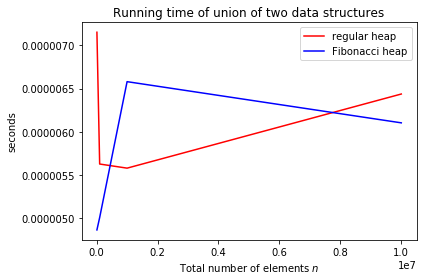

In [34]:
union_exp()

Running times for regular heap: [5.054473876953125e-06, 5.9604644775390625e-06, 5.578994750976562e-06, 5.4836273193359375e-06]
Running times for Fibonacci heap: [5.197525024414063e-06, 4.434585571289063e-06, 5.197525024414063e-06, 4.9591064453125e-06]


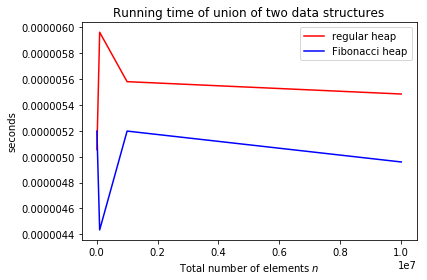

In [35]:
union_exp()

There is a good amount of evidence that Fibonacci heaps perform consistently better than the regular heaps when it comes to making a union of two heaps. The exception occurs in the 3rd graph, where regular heap outperforms FIbonacci heap. However, we do note that at the end, where $n$ is large, Fibonacci heap is still superior.

## The Decrease-key Operation

* For regular heaps: 

As aforementioned, this operation first adds the node with key $\infty$ to the heap and then continually swaps the key with its parent until the min-heap invariant is preserved. In the worst case, the inserted node has to travel a distance of $h=\Theta(log\:n)$ all the way from the leave to the root, so the run time of this operation is $T=\Theta(h)=\Theta(log\:n)$

* For Fibonacci heaps:

Cormen et al. used the method of potential function (as opposed to the aggregrate analysis and the accounting method) to make the amortized analysis. The summary of this method is as follows:
1. Choose a potential function $f(H_i)$ associated with the state $H_i$ of the heap so that $f(H_i)$ is always no smaller than the potential of the initial heap ($f(H_i)>f(H_0)$). We choose 
$$f(H_i)=H.num\_trees+2\times H.num\_marks$$
Initially, the heap is empty, so $H_0.num\_trees=0$ and $H_0.num\_marks=0$, so $f(H_i)>f(H_0)=0$ for all states $H_i$.
2. Calculate the change in potential $\Delta f$ after performing the operation. Suppose before the operation decrease-key, the number of trees is $t$ and the number of marked nodes is $m$. If during the operation, there are $c$ nodes being cut and added to the root list, then after the operation, the number of trees is $t+c$ and the number of marked nodes is at most $m-c+2$. The change in potential is, therefore:
$$\Delta f=-(t+2m)+(t+c-2(m-c+2))=-(c-4)=4-c$$
3. We know that the actual running time is $O(c)$, since the operation has to cut $c$ nodes and each cut costs constant time. The amortized time of the operation equals the actual run time plus the change in potential:
$$T=O(c)+\Delta f=O(c)+4-c=O(1)$$
We have the above result because, according to Cormen et al., "we can [always] scale up the units of potential to dominate the constant hidden in O.c/"

Below is the experiment of the practical run time of decrease-key. As the library `heapq` does not support decrease-key, I will paste below my own code for the min heap operations that include decrease-key.

In [48]:
class PriorityQueue:
    """ Binary min-heap"""
    def __init__(self):
        self.heap = []

    def __len__(self):
        return len(self.heap)

    def min(self):
        return self.heap[0]

    def left(self, i):
        return 2*i + 1

    def right(self,i):
        return 2*i + 2

    def parent(self,i):
        return (i-1)//2

    def min_heapify(self, i):
        l = 2*i+1
        r = 2*i+2
        heap = self.heap
        if l <= (len(heap)-1) and heap[l]<heap[i]:
            smallest = l
        else:
            smallest = i
        if r <= (len(heap)-1) and self.heap[r] < self.heap[smallest]:
            smallest = r
        if smallest != i:
            holder = self.heap[i]
            self.heap[i] = self.heap[smallest]
            self.heap[smallest] = holder
            self.min_heapify(smallest)

    def pop(self):
        if len(self.heap) < 1:
            raise ValueError('Heap underflow')
        min = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.min_heapify(0)
        return min

    def decrease_key(self, i, key):
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] > self.heap[i]:
            holder = self.heap[self.parent(i)]
            self.heap[self.parent(i)] = self.heap[i]
            self.heap[i] = holder
            i = self.parent(i)

    def append(self, key):
        self.heap.append(float("inf"))
        self.decrease_key(len(self.heap)-1,key)

In [51]:
### TEST PriorityQueue###
queue = PriorityQueue()
a = [1,6,4,2]
for num in a:
    queue.append(num)
queue.decrease_key(3,-10)
for _ in range(len(queue)):
    print(queue.pop())

-10
1
2
4


In [52]:
def dec_key_exp(iterations):
    N = []
    prev_i = 1
    heap = PriorityQueue()
    fheap = Fheap()
    heap_times, fheap_times = [], []
    for i in np.logspace(0,7,50):
        N.append(i)        
        num_list = list(range(int(prev_i),int(i)+1))
        np.random.shuffle(num_list)
        nodes = []
        for num in num_list:
            heap.append(num)
            nodes.append(Node(num))
        for node in nodes:
            fheap.insert(node)
        heap_time, fheap_time = 0, 0
        for j in range(iterations):
            start = time.time()
            heap.decrease_key(len(heap)-1, -1-j)
            heap_time = heap_time + time.time()-start
            
            start = time.time()
            fheap.decrease_key(nodes[-1], nodes[-1].key-j-1)
            fheap_time = fheap_time + time.time() - start
        
        heap_times.append(heap_time/iterations)
        fheap_times.append(fheap_time/iterations)
        prev_i = i
    
    plt.plot(N, heap_times, color='red',
             label='regular heap')
    plt.plot(N, fheap_times, color='blue',
             label='Fibonacci heap')
    title = 'Running time of decrease-key of two data structures'
    plt.title(title)
    plt.xlabel('number of elements in the heap $n$')
    plt.ylabel('seconds')
    plt.legend()
    plt.show()
    return heap_times, fheap_times
        

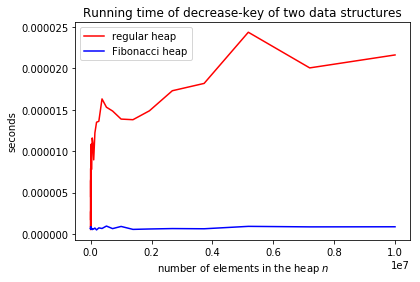

In [55]:
dec_key_exp1 = dec_key_exp(100) 

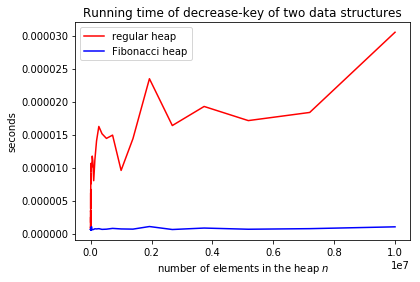

In [57]:
dec_key_exp2 = dec_key_exp(100)

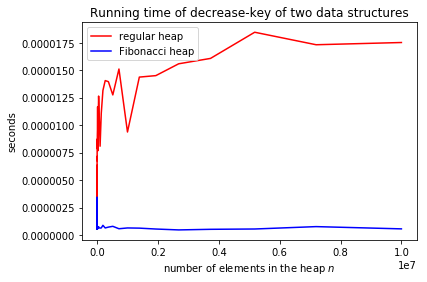

In [58]:
dec_key_exp3 = dec_key_exp(100)

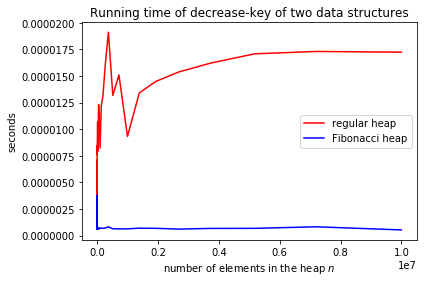

In [59]:
dec_key_exp4 = dec_key_exp(100)

This is the case where the practical results align with the theoretical analyis the best: 
1. we see that FIbonacci heap implements decrease-key in constant time (the blue curve stays virtually flat in all four graphs
2. the curves for regular heap, although noisy and jagged, have the general form of $\Theta(log\:n)$ (the clearest shapes are in graph 1, 3, and 4.)

# Discussions

Despite the claim in various papers in the field that Fibonacci heap performs poorly in practice and therefore is the domain of theoretical analysis primarily, this paper gives evidence that this claim is only true to some extent. Of the three experiment sets on three operations, the only operation in which the Fibonacci heap is clearly inferior to the regular heap is the insert one. For the other two operations (union and decrease-key), there is a strong evidence that Fibonacci heap is a better choice. Additionally, the last experiment set on the decrease-key operation shows that the theoretical and the empirical results are in agreement.

Fibonacci, therefore, could still be useful and appropriate to use in applications in which the number of union and decrease-key operations are large compared to the number of insertions. Consequently, I decided to distribute the `fibheap` package, with a belief that the data structure can still be useful even in practice.

This paper could be improved by more experiments on the other four operations (make-heap, minimum, extract-min, and delete).

# Reference

Brodal, G. S., Lagogiannis, G., & Tarjan, R. E. (2012, May). Strict fibonacci heaps. In Proceedings of the forty-fourth annual ACM symposium on Theory of computing (pp. 1177-1184). ACM.

Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). Introduction to algorithms. MIT press.